# Detect anomalies with PCA on all signals

## Import and input

In [7]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
import numpy as np
from matplotlib import pyplot as plt


train1 = pd.read_csv('../data/training_1.csv')
train2 = pd.read_csv('../data/training_2.csv')

## Data preparation for PCA

In [8]:
# store all time points of known attacks
labels = list(train2.loc[train2['ATT_FLAG']==1].index)

# remove non-sensor data
train1 = train1.loc[:,train1.columns!='ATT_FLAG']
series = train1.loc[:,train1.columns!='DATETIME']
train2 = train2.loc[:,train2.columns!='ATT_FLAG']
series2 = train2.loc[:,train2.columns!='DATETIME']



## Define PCA process for anomaly detection

In [9]:
def pca_residuals(series,series2):
    # PCA requires normalized data
    normalizer = Normalizer()
    normalized_series =pd.DataFrame(normalizer.fit_transform(series))

    normalizer2 = Normalizer()
    normalized_series2 = pd.DataFrame(normalizer2.fit_transform(series2))

    # use PCA and find the importance of each principal component
    pca = PCA()
    pca.fit(normalized_series)
    print(pca.explained_variance_ratio_)
    
    # use most significant components to capture data behavior
    pca2 = PCA(n_components=7)
    pca2.fit(normalized_series)
    
    # project both the normal and anomalous data in the 7D Principal Component space
    projection = pca2.transform(normalized_series)
    projection2 = pca2.transform(normalized_series2)
    
    # use the 7 principal components to project the data back to the original space
    components = pca2.components_
    recreation = np.matmul(projection,components)
    recreation2 =  np.matmul(projection2,components)
    
    # calculate the residual per signal 
    residuals = np.subtract(np.array(normalized_series),recreation)
    residuals2 = np.subtract(np.array(normalized_series2),recreation2)
    
    # combine the residuals of all signals for each point in time
    residual = np.sum(np.square(residuals),axis=1)
    residual2 = np.sum(np.square(residuals2),axis=1)
    
    return residual, residual2

## Perform PCA

[4.17069326e-01 2.84623976e-01 9.49846165e-02 8.02669313e-02
 6.66072167e-02 3.54455113e-02 1.09027636e-02 3.55783644e-03
 2.05053375e-03 1.34806571e-03 1.04592992e-03 6.21398354e-04
 4.44894278e-04 2.91654098e-04 2.04017340e-04 1.30103613e-04
 1.12740210e-04 8.32099950e-05 6.45947251e-05 5.49207265e-05
 3.32930788e-05 2.89940320e-05 2.32243860e-05 2.91336032e-06
 6.09480342e-07 3.81642611e-07 1.42621985e-07 5.43278403e-08
 4.76266637e-08 3.12523788e-08 2.88499241e-08 2.65816798e-08
 5.02432048e-09 4.34886828e-09 1.58380651e-09 1.42419291e-09
 2.87324611e-11 2.56272105e-33 2.56272105e-33 2.56272105e-33
 2.56272105e-33 2.56272105e-33 2.56272105e-33]


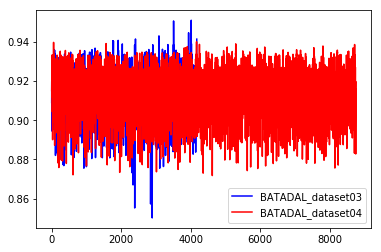

In [4]:
residual, residual2 = pca_residuals(series,series2)

# plot the residuals for both datasets and compare them
plt.plot(residual,'b')
plt.plot(residual2,'r')
plt.legend(['BATADAL_dataset03','BATADAL_dataset04'])
plt.show()

## Repeat PCA after data cleaning

In [5]:
# remove signals that increase residual error
series= series.drop(labels=['L_T1','P_J415','P_J256','P_J306','P_J317','F_PU11','P_J14','P_J422','P_J269','F_PU7','P_J289','P_J300','P_J302','P_J307','F_V2'],axis=1) 
series2= series2.drop(labels=['L_T1','P_J415','P_J256','P_J306','P_J317','F_PU11','P_J14','P_J422','P_J269','F_PU7','P_J289','P_J300','P_J302','P_J307','F_V2'],axis=1) 

residual, residual2 = pca_residuals(series,series2)

[7.13169111e-01 1.19221680e-01 9.88389120e-02 5.13342339e-02
 1.59039420e-02 6.51799257e-04 2.76635131e-04 1.90718002e-04
 1.29905702e-04 1.08784976e-04 8.53253426e-05 4.26256704e-05
 3.39038358e-05 8.24764699e-06 2.83854283e-06 8.83129530e-07
 1.41502725e-07 1.34989304e-07 6.67858421e-08 5.98220155e-08
 4.95590958e-08 3.13728560e-10 5.63725231e-33 5.63725231e-33
 5.63725231e-33 5.63725231e-33 5.63725231e-33 5.63725231e-33]


## Evaluate PCA results

In [6]:
# set the conditions for anomalous behavior
threshold1 = np.max(residual)
threshold2 = np.min(residual)
detected_indices = np.where((residual2>threshold1))
detected_rows = detected_indices[0]
unique_rows = set(detected_rows)
        
detected_indices = np.where((residual2<threshold2))
detected_rows = detected_indices[0]
for time_point in detected_rows:
    unique_rows.add(time_point)
unique_rows = list(unique_rows)
unique_rows.sort()

# compute conservative True Positives and False Positives
TP = 0
FP = 0
for j in unique_rows:
    if j in labels:
        TP +=1
    else:
        FP +=1                
        
print(TP)
print(FP)

0
0
